In [9]:
push!(LOAD_PATH,"../../package/QuantumCircuits_demo/src","../../package/VQC_demo_cuda/src")
using VQC
using QuantumCircuits, QuantumCircuits.Gates
using DelimitedFiles
using Random
using Flux.Optimise:ADAM,update!
using Base.Threads
using Statistics
using StatsBase
using Zygote
using Zygote: @adjoint
using Base: @kwdef
using Plots
using CUDA
using JLD2

In [10]:
function build_circuit_zx(N,nlayer)
    circuit = QCircuit()
    for k in 1:nlayer
        for j=1:N
            push!(circuit, RxGate(j, rand(), isparas=true))
            push!(circuit, RzGate(j, rand(), isparas=true))
            push!(circuit, RxGate(j, rand(), isparas=true))
        end 
        for j=1:N-1
            push!(circuit,CNOTGate(j,j+1))
        end
    end
    push!(circuit, RxGate(mq[1], rand(), isparas=true))
    push!(circuit, RzGate(mq[1], rand(), isparas=true))
    push!(circuit, RxGate(mq[1], rand(), isparas=true))
    return circuit
end


function loss_util(circuit,data_batch,label_batch)
    loss_value = 0.
    out=circuit*data_batch
    p01=real.(expectation(B[1],out))
    L=length(p01)
    p1=p01
    p2=-p01.+1
    loss_value -= dot(label_batch[1,:],log.(p1))
    loss_value -= dot(label_batch[2,:],log.(p2))
    return loss_value/L
end


function fprediction_util(circuit::QCircuit,data_set)#输出预测向量.
    L=nitems(data_set)
    preds=zeros(2,L)
    x=circuit*data_set
    p=real(expectation(B[1],x)) #测量第一个比特0的概率
    preds[1,:]=p
    preds[2,:]=-p.+1
    return preds
end

function fprediction_util(circuits::Vector{QCircuit},data_set)#输出预测向量.
    L=nitems(data_set)
    preds=zeros(2,L)
    for circuit in circuits
        x=circuit*data_set
        p=real(expectation(B[1],x)) #测量第一个比特0的概率
        preds[1,:].+=p
        preds[2,:].+=(-p.+1)
    end
    return preds
end

function fprediction(circuits::Vector{QCircuit},data_set)#输出预测向量.
    L=nitems(data_set)
    preds=fprediction_util(circuits::Vector{QCircuit},data_set)./length(circuits)
    for i in 1:L
        preds[1,i]>0.5 && (preds[:,i]=[1.,0.])
        preds[1,i]<0.5 && (preds[:,i]=[0.,1.])
    end
    return preds
end

fprediction (generic function with 1 method)

In [11]:
h1_vals = [0.1000, 0.2556, 0.4111, 0.5667, 0.7222, 0.8778, 1.0333, 1.1889, 1.3444, 1.5000]
anti_ferro_mag_boundary = [-1.004, -1.0009, -1.024, -1.049, -1.079, -1.109, -1.154,  -1.225, -1.285, -1.35]
para_mag_boundary = [0.8439, 0.6636, 0.5033, 0.3631, 0.2229, 0.09766, -0.02755, -0.1377, -0.2479, -0.3531];

In [28]:
@kwdef mutable struct Args
    η::Float64 = 5e-3       ## learning rate
    batchsize::Int = 40    ## batch size
    epochs::Int = 500      ## number of epochs
end
global args = Args(;)
#分类类别
global const K=2
global N=9
global nlayer=2

global mq=[N] #measure_qubits
#测量算子
UP=[1 0; 0 0]
DOWN=[0 0; 0 1]
const B=[QubitsTerm(mq[1]=>UP),QubitsTerm(mq[1]=>"X"),QubitsTerm(mq[1]=>DOWN)]
Samples=400
interval=0.01
datas = readdlm("SPT_train_set_$(N)_$(Samples).csv",',', Float64)
labels = readdlm("SPT_train_label_$(N)_$(Samples).csv",',')
dm=CuStateVectorBatch(CuArray(datas),N,Samples)
C=10

10

In [32]:
circuits = Vector{QCircuit}()
for c in 1:C
    circuit = build_circuit_zx(N,nlayer)
    opt=ADAM(args.η)
    params = parameters(circuit)
    for iter = 1:args.epochs
        grad = gradient(x->loss_util(x,dm,labels),circuit)[1]
        update!(opt, params,grad)
        reset_parameters!(circuit, params)
    end
    push!(circuits,circuit)

    #测试当前线路集性能
    x1=fprediction(circuits,dm)
    re1=dot(x1,labels)
    x2=fprediction([circuit],dm)
    re2=dot(x2,labels)
    println("$(c)th classifier_acc:$(sum(re2)/Samples); the random forest acc:$(sum(re1)/Samples)")
end 

DomainError: DomainError with -4.440892098500626e-16:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [14]:
test_set= readdlm("SPT_test_set_$(N).csv",',', Float64)

32768×4096 Matrix{Float64}:
 -0.00561586   0.0118425    -0.00632842  …  0.0103118   -0.0101894
 -0.00884046   0.00256101   -0.00902235     0.00916377  -0.00907519
  0.00628531   0.00189202    0.00597232     0.00952307  -0.00942408
  0.00576491  -0.0108404     0.00643108     0.00812608  -0.00806938
 -0.00903942   0.0042943    -0.00925983     0.00852453  -0.00845132
 -0.00612417   0.0102764    -0.00673314  …  0.00938734  -0.00929402
  0.00675873  -0.011349      0.00745898     0.00727446  -0.00724178
  0.00672908   7.81627e-6    0.00650743     0.00844542  -0.00838102
  0.00510089   0.00321291    0.00462322     0.0088133   -0.00873264
  0.00341469  -0.00922231    0.00368441     0.00755234  -0.00750778
  ⋮                                      ⋱               ⋮
 -0.00161847   0.00855386   -0.00173245     0.0088133   -0.00873264
 -0.00408277   0.00884668   -0.00435541  …  0.00844542  -0.00838102
 -0.00944824   0.00223253   -0.00970906     0.00727446  -0.00724178
  0.00858793  -0.00201202    0

In [17]:
res_pix=zeros(64,64)
res = zeros(64,64)
for i in 1:64
    test_dm = CuStateVectorBatch(CuArray(test_set[:,(i-1)*64+1:i*64]),N,64)
    re=fprediction(circuits[1:5],test_dm);
    res[:,i]=re[1,:]
end

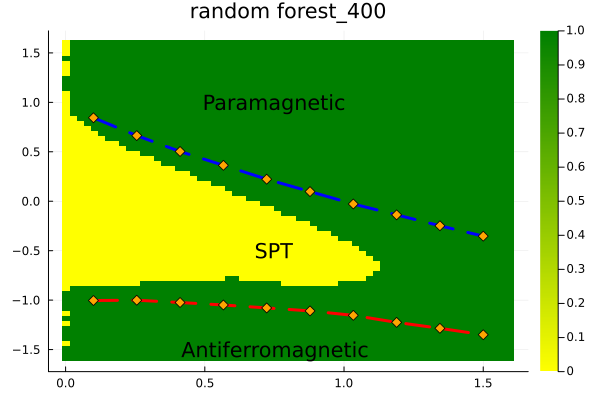

In [18]:
heatmap(LinRange(0,1.6,64),LinRange(-1.6,1.6,64),res,c=cgrad([:yellow,:green]))
plot!(h1_vals,[anti_ferro_mag_boundary para_mag_boundary],markershapes=:diamond,markersize=5,lw=3,linestyle=:dash,lc=["red" "blue"],mc=:orange,fc="white",legend=false,title="random forest_$(Samples)")
annotate!([0.75 0.75 0.75] ,[1 -1.5 -0.5],["Paramagnetic","Antiferromagnetic", "SPT"])

In [19]:
# save("random_forest_$(Samples)_$(N)q_$(nlayer)_$(interval)_10.jld2","circuits",circuits,"res",res)